### Task VIII: Vision transformer/Quantum Vision Transformer

Implement a classical Vision transformer and apply it to MNIST. Show its performance on the test data. Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm

#### Implementation of Vision Transformer (ViT)

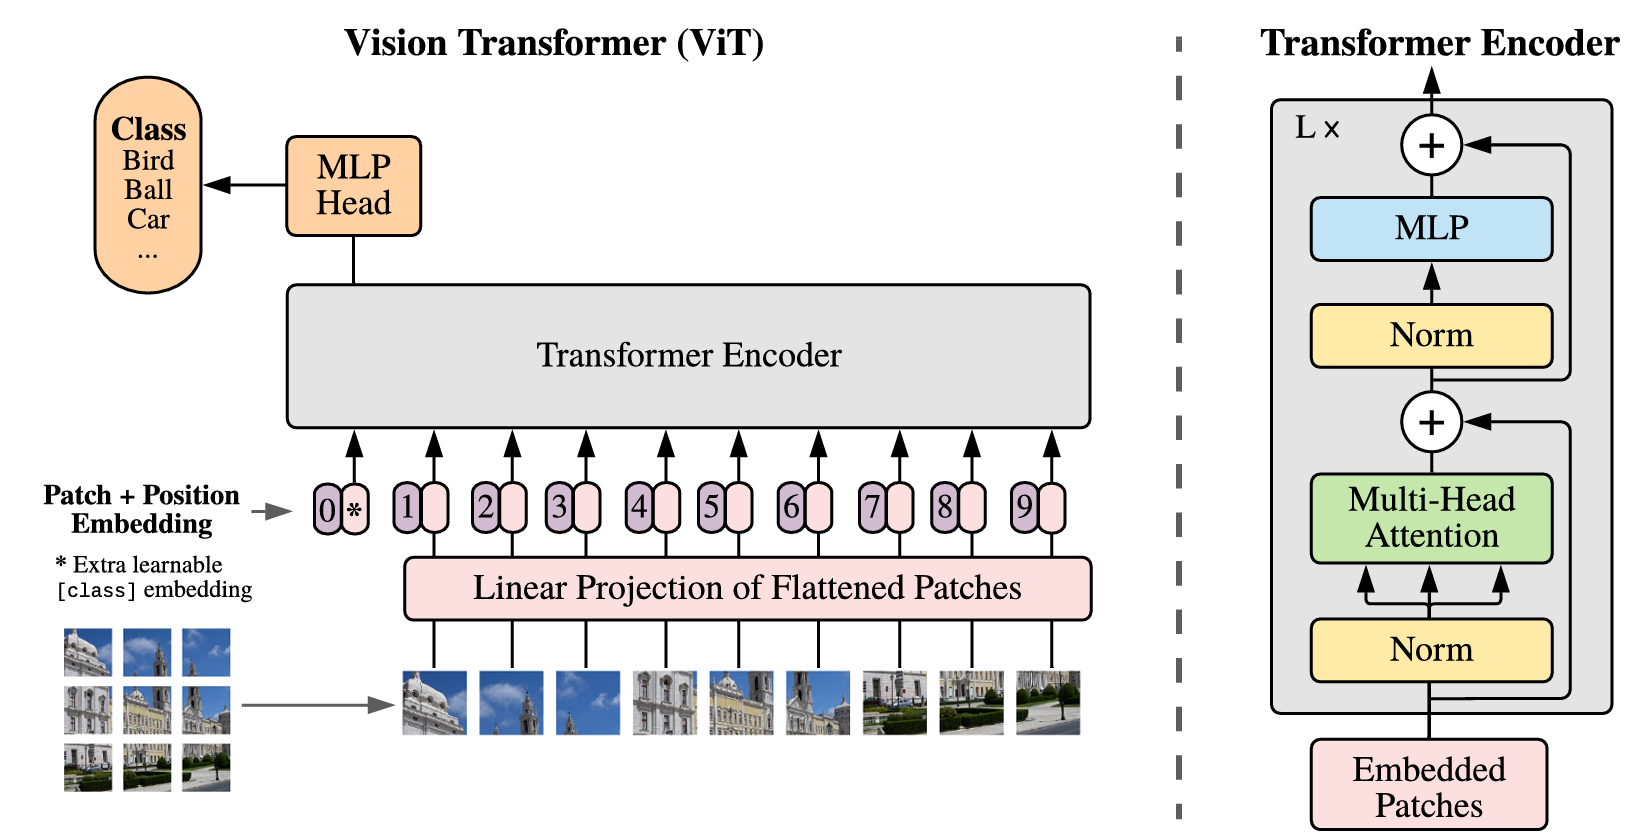

Source: [1]

The `PatchEmbedding` class prepares the input image for processing by the Transformer Encoder. It reformats the image into a series of fixed-size patches and projects these patches into an embedding space, which allows Vision Transformer to process images in a similar manner to how Transformers in NLP process sequences of word embeddings:

In [20]:
class PatchEmbedding(nn.Module):
    """
    Implementation of patch embedding encoding layer.

    Args:
        image_size (int): The height and width of the square input image.
        
        patch_size (int): The height and width of each patch. 
        Each input image will be split into (image_size // patch_size) ** 2 patches.

        in_channels (int): The number of input channels (default grayscale)

        embed_dim (int): The embedding dimension to project each patch.

    """
    def __init__(self, image_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B is the batch size, C is the number of channels, H and W are the height and width
        x = self.proj(x)  # [B, E, H, W]
        x = x.flatten(2)  # [B, E, N]
        x = x.transpose(1, 2)  # [B, N, E]
        return x

The `PositionalEmbedding` class introduces a learnable positional embedding to the patch embeddings of an image. The positional embeddings are learned during training and are added to the patch embeddings to provide the model with positional context for each patch:

In [23]:
class PositionalEmbedding(nn.Module):
    """
    Introduces learnable positional embeddings to patch embeddings.

    Args:
        seq_len (int): Number of patches per image.
        
        embed_dim (int): Dimensionality of patch embeddings.
        
    """
    def __init__(self, seq_len, embed_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.zeros(1, seq_len, embed_dim))

    def forward(self, x):
        return x + self.pos_embed # same shape as the input [B, seq_len, embed_dim].

The `TransformerEncoder` class is a core component of the Transformer, adapted here for Vision Transformer (ViT) model. It includes a single encoder layer of the Transformer, which processes sequences of embeddings i.e patch embeddings from an image.The use of residual connections in self-attention and feedforward network helps mitigate the vanishing gradient problem in deep networks.

In [24]:
class TransformerEncoder(nn.Module):
    """
    A single layer of the Transformer encoder.

    Performs self-attention and applies a feedforward neural network to sequences of embeddings.

    Args:
        embed_dim (int): Dim of input embeddings.
        
        num_heads (int): Num of heads in the multi-head attention.
        
        ff_dim (int): Dim of the hidden layer in the feedforward network.
        
        dropout (float): Dropout rate.
        
    """
    def __init__(self, embed_dim=64, num_heads=2, ff_dim=128, dropout=0.1):
        super().__init__()
        # Multi-head self-attention mechanism
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        # First linear layer
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Second linear layer
        self.linear2 = nn.Linear(ff_dim, embed_dim)
        # Normalization applied before self-attention and feedforward network
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        # Activation function within the feedforward network
        self.activation = nn.GELU()

    def forward(self, src):
        """
        Processes input through one encoder layer.

        Args:
            src (torch.Tensor): Input sequence of embeddings with shape [seq_len, batch_size, embed_dim].

        Returns:
            torch.Tensor: Output sequence of processed embeddings.
        """
        # Apply normalization, then self-attention, with a residual connection
        src2 = self.norm1(src)
        src = src + self.self_attn(src2, src2, src2)[0]
        # Apply normalization, then the feedforward network, with a residual connection
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout(src2)
        return src

Finally, the `ViT` class implementing a Vision Transformer is constructed with the implemented classes as follow:

In [25]:
class ViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, in_channels, embed_dim, num_heads, ff_dim, num_layers):
        super().__init__()
        seq_length = (image_size // patch_size) ** 2
        self.patch_embedding = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.positional_embedding = PositionalEmbedding(seq_length, embed_dim)
        self.transformer_encoders = nn.Sequential(*[TransformerEncoder(embed_dim, num_heads, ff_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.positional_embedding(x)
        x = self.transformer_encoders(x)
        x = x.mean(dim=1)  # Use mean pooling
        x = self.classifier(x)
        return x

Next, we'll evaluate the Vision Transformer (ViT) model using the MNIST dataset.

In [18]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,)),  # Normalize MNIST dataset
])

# Load MNIST dataset
train_dataset_ = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8 * len(train_dataset_))
val_size = int(0.2 * len(train_dataset_))

print("Train Dataset Size: ", train_size)
print("Val Dataset Size  : ", val_size)
print("Test Dataset Size : ", len(test_dataset))

# Split the full training dataset into training and validation
train_dataset, val_dataset = random_split(train_dataset_, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Train Dataset Size:  48000
Val Dataset Size  :  12000
Test Dataset Size :  10000


In [19]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = ViT(image_size=28, 
            patch_size=7, 
            num_classes=10, 
            in_channels=1, 
            embed_dim=64, 
            num_heads=2, 
            ff_dim=128, 
            num_layers=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from torchsummary import summary
summary(model, input_size=(1, 28, 28))

# Training
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_loader_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training")
    for images, labels in train_loader_progress:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_accuracy = 100 * val_correct / val_total

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Testing
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total} %')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 4, 4]           3,200
    PatchEmbedding-2               [-1, 16, 64]               0
PositionalEmbedding-3               [-1, 16, 64]               0
         LayerNorm-4               [-1, 16, 64]             128
MultiheadAttention-5  [[-1, 16, 64], [-1, 2, 2]]               0
         LayerNorm-6               [-1, 16, 64]             128
            Linear-7              [-1, 16, 128]           8,320
              GELU-8              [-1, 16, 128]               0
           Dropout-9              [-1, 16, 128]               0
           Linear-10               [-1, 16, 64]           8,256
          Dropout-11               [-1, 16, 64]               0
TransformerEncoder-12               [-1, 16, 64]               0
        LayerNorm-13               [-1, 16, 64]             128
MultiheadAttention-14  [[-1, 16, 64]

Epoch 1/10 Training:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/10 Training: 100%|██████████| 750/750 [00:14<00:00, 50.12it/s]


Epoch 1/10, Loss: 0.8314, Val Accuracy: 87.88%


Epoch 2/10 Training: 100%|██████████| 750/750 [00:15<00:00, 49.27it/s]


Epoch 2/10, Loss: 0.3209, Val Accuracy: 91.57%


Epoch 3/10 Training: 100%|██████████| 750/750 [00:14<00:00, 51.78it/s]


Epoch 3/10, Loss: 0.2291, Val Accuracy: 93.92%


Epoch 4/10 Training: 100%|██████████| 750/750 [00:14<00:00, 52.30it/s]


Epoch 4/10, Loss: 0.1873, Val Accuracy: 95.26%


Epoch 5/10 Training: 100%|██████████| 750/750 [00:15<00:00, 48.69it/s]


Epoch 5/10, Loss: 0.1638, Val Accuracy: 95.46%


Epoch 6/10 Training: 100%|██████████| 750/750 [00:18<00:00, 40.62it/s]


Epoch 6/10, Loss: 0.1446, Val Accuracy: 95.64%


Epoch 7/10 Training: 100%|██████████| 750/750 [00:14<00:00, 50.64it/s]


Epoch 7/10, Loss: 0.1331, Val Accuracy: 95.97%


Epoch 8/10 Training: 100%|██████████| 750/750 [00:15<00:00, 49.06it/s]


Epoch 8/10, Loss: 0.1244, Val Accuracy: 96.62%


Epoch 9/10 Training: 100%|██████████| 750/750 [00:14<00:00, 51.08it/s]


Epoch 9/10, Loss: 0.1147, Val Accuracy: 96.38%


Epoch 10/10 Training: 100%|██████████| 750/750 [00:15<00:00, 49.61it/s]


Epoch 10/10, Loss: 0.1087, Val Accuracy: 96.58%
Test Accuracy: 96.84 %


#### Quantum Vision Transformer

The adaptation of quantum computing to ViT would primarily involve incorporating quantum operations on different layers of the classical model. 

1. **Quantum Patch Embedding**:
   - **Classical Approach**: In ViT, an image is divided into patches, which are then linearly projected into an embedding space.
   - **Quantum Extension**: Use a quantum circuit to perform the embedding of image patches. Each patch can be encoded into qubits using amplitude, angle, etc. encoding strategies, and a quantum circuit can then manipulate these qubit states to generate quantum embeddings.

2. **Quantum Positional Encoding**:
   - **Classical Approach**: Positional information is added to embeddings to preserve the spatial structure of the image.
   - **Quantum Extension**: Use a quantum circuit to add phase shifts or other quantum state manipulations to encode positional information into the quantum states representing patch embeddings.

3. **Quantum Transformer Blocks**:
   - **Classical Approach**: Transformer blocks process the sequence of embeddings using self-attention and feedforward neural networks.
   - **Quantum Extension**: Each transformer block could be a combination of quantum self-attention circuits followed by quantum feedforward circuits, utilizing parameterized quantum gates to learn and process information. This would involve using quantum gates to model interactions between qubits representing different patches, utilizing quantum entanglement to model complex relationships.

4. **Global Pooling and Classification**:
   - **Classical Approach**: The output of the transformer blocks is pooled to a single vector, which is then passed to a classifier.
   - **Quantum Extension**: The pooling operation could be implemented as a quantum measurement, collapsing the quantum state to a classical representation suitable for classification.


Following is a sketch of QViT with the 3rd approach "Quantum Transformer Blocks": 

In [1]:
class VQC:
    def __init__(self, circuit, num_qubits):
        self.circuit = circuit
        self.num_qubits = num_qubits

    def forward(self, x):
        w = initialize_weights(self.num_qubits)
        x = self.circuit(x, w)
        return x

class MultiHeadAttention:
    def __init__(self, hidden_size, num_heads, dropout, quantum_circuit):
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.quantum_circuit = quantum_circuit

    def forward(self, x):
        # Prepare queries, keys, and values
        q, k, v = [
            VQC(circuit=self.quantum_circuit, num_qubits=hidden_size).forward(x)
            .reshape() # reshape logic for the right dimension
            for _ in range(3)
        ]
        
        # Compute scaled dot product attention
        attn = scaled_dot_product_attention(q, k, v)

        # Apply dropout to the attention scores
        attn = apply_dropout(attn, self.dropout)
        
        # Output processing
        return output_processing(attn)

class FeedForward:
    def __init__(self, hidden_size, mlp_hidden_size, dropout, quantum_circuit):
        self.hidden_size = hidden_size
        self.mlp_hidden_size = mlp_hidden_size
        self.dropout = dropout
        self.quantum_circuit = quantum_circuit

    def forward(self, x):
        x = apply_nonlinearity(x)
        x = VQC(circuit=self.quantum_circuit, num_qubits=hidden_size).forward(x)
        x = apply_dropout(x, self.dropout)
        return x

class TransformerBlock:
    def __init__(self, hidden_size, num_heads, mlp_hidden_size, dropout, attn_qc, mlp_qc):
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.mlp_hidden_size = mlp_hidden_size
        self.dropout = dropout
        self.attn_qc = attn_qc
        self.mlp_qc = mlp_qc

    def forward(self, x):
        attn_output = apply_layer_norm(x)
        attn_output = MultiHeadAttention(self.hidden_size, self.num_heads,
                                             self.dropout, self.attn_qc).forward(attn_output)
        x += attn_output

        ff_output = apply_layer_norm(x)
        ff_output = FeedForward(self.hidden_size, self.mlp_hidden_size, 
                                                self.dropout, self.mlp_qc).forward(ff_output)
        x += ff_output
        return x

class VisionTransformer:
    def __init__(self, num_classes, patch_size, hidden_size, num_heads, 
    num_transformer_blocks, mlp_hidden_size, dropout, attn_qc, mlp_qc):
        self.num_classes = num_classes
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.num_transformer_blocks = num_transformer_blocks
        self.mlp_hidden_size = mlp_hidden_size
        self.dropout = dropout
        self.attn_qc = attn_qc
        self.mlp_qc = mlp_qc

    def forward(self, x):
        x = preprocess_input(x, self.patch_size, self.hidden_size)
        
        # Add positional embedding
        x += get_positional_embedding(x, self.hidden_size)

        # Process each transformer block
        for _ in range(self.num_transformer_blocks):
            x = TransformerBlock(self.hidden_size, self.num_heads, self.mlp_hidden_size, 
                                self.dropout, self.attn_qc, self.mlp_qc).forward(x)
        
        # Prepare for classification: normalizaing, pooling, etc.
        x = apply_layer_norm(x)
        x = apply_pooling(x)
        
        # Classification
        logits = classify(x, self.num_classes)
        return logits


#### References

* [1] A. Dosovitskiy et al., “An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale.” arXiv, Jun. 03, 2021. Accessed: Apr. 05, 2024. [Online]. Available: http://arxiv.org/abs/2010.11929
